In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from os import path

In [2]:
datos = pd.read_csv("20220617_NEM_PERCENTILES_JOVENES_2021_20220530_PUBL.csv", sep=";")

In [3]:
datos

,RBD,COD_DEPE,AGNO_EGRESO,MRUN,NEM,PERCENTIL,PUESTO_10,PUESTO_30
0,8424,1,2021,122,"5,78",30,NO,SI
1,2200,4,2021,163,"6,85",20,NO,SI
2,40023,4,2021,164,"6,53",40,NO,NO
3,8923,4,2021,429,"6,7",60,NO,NO
4,10500,3,2021,488,"5,3",60,NO,NO
...,...,...,...,...,...,...,...,...
207697,286,1,2021,27072968,"6,2",10,SI,NO
207698,109,1,2021,27072971,"5,03",90,NO,NO
207699,106,5,2021,27072972,"5,33",80,NO,NO
207700,11831,1,2021,27072973,"6,08",20,NO,SI


In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207702 entries, 0 to 207701
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   RBD          207702 non-null  int64 
 1   COD_DEPE     207702 non-null  int64 
 2   AGNO_EGRESO  207702 non-null  int64 
 3   MRUN         207702 non-null  int64 
 4   NEM          207702 non-null  object
 5   PERCENTIL    207702 non-null  int64 
 6   PUESTO_10    207702 non-null  object
 7   PUESTO_30    207702 non-null  object
dtypes: int64(5), object(3)
memory usage: 12.7+ MB


In [5]:
datos["RBD"] = datos["RBD"].astype("category")
datos["NEM"] = datos["NEM"].str.replace(",",".")
datos["NEM"] = datos["NEM"].astype(np.float64)


In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207702 entries, 0 to 207701
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   RBD          207702 non-null  category
 1   COD_DEPE     207702 non-null  int64   
 2   AGNO_EGRESO  207702 non-null  int64   
 3   MRUN         207702 non-null  int64   
 4   NEM          207702 non-null  float64 
 5   PERCENTIL    207702 non-null  int64   
 6   PUESTO_10    207702 non-null  object  
 7   PUESTO_30    207702 non-null  object  
dtypes: category(1), float64(1), int64(4), object(2)
memory usage: 11.6+ MB


In [7]:
agrupacion_promedios = datos.groupby(by = "RBD").mean().reset_index()

In [8]:
directorio = pd.read_csv("Directorio_Oficial_EE_2021.csv", sep=";")

In [9]:
directorio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16498 entries, 0 to 16497
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AGNO            16498 non-null  int64 
 1   RBD             16498 non-null  int64 
 2   DGV_RBD         16498 non-null  int64 
 3   NOM_RBD         16468 non-null  object
 4   MRUN            16498 non-null  object
 5   RUT_SOSTENEDOR  16498 non-null  object
 6   P_JURIDICA      16498 non-null  int64 
 7   COD_REG_RBD     16498 non-null  int64 
 8   NOM_REG_RBD_A   16498 non-null  object
 9   COD_PRO_RBD     16498 non-null  int64 
 10  COD_COM_RBD     16498 non-null  int64 
 11  NOM_COM_RBD     16498 non-null  object
 12  COD_DEPROV_RBD  16498 non-null  int64 
 13  NOM_DEPROV_RBD  16498 non-null  object
 14  COD_DEPE        16498 non-null  int64 
 15  COD_DEPE2       16498 non-null  int64 
 16  RURAL_RBD       16498 non-null  int64 
 17  LATITUD         16498 non-null  object
 18  LONGIT

In [10]:
directorio = directorio[directorio["NOM_RBD"].str.contains("JARDIN+|SALA CUNA+", regex=True) == False]

In [11]:
directorio["LONGITUD"] = directorio["LONGITUD"].replace(" ", np.nan)
directorio["LATITUD"] = directorio["LATITUD"].replace(" ", np.nan)
directorio.dropna()
directorio["LONGITUD"] = directorio["LONGITUD"].str.replace(",",".").astype(np.float64)
directorio["LATITUD"] = directorio["LATITUD"].str.replace(",",".").astype(np.float64)


In [12]:
localizaciones = gpd.GeoDataFrame(directorio, geometry= gpd.points_from_xy(directorio["LONGITUD"], directorio["LATITUD"]), crs=4326)

In [13]:
localizaciones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15584 entries, 0 to 16495
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   AGNO            15584 non-null  int64   
 1   RBD             15584 non-null  int64   
 2   DGV_RBD         15584 non-null  int64   
 3   NOM_RBD         15584 non-null  object  
 4   MRUN            15584 non-null  object  
 5   RUT_SOSTENEDOR  15584 non-null  object  
 6   P_JURIDICA      15584 non-null  int64   
 7   COD_REG_RBD     15584 non-null  int64   
 8   NOM_REG_RBD_A   15584 non-null  object  
 9   COD_PRO_RBD     15584 non-null  int64   
 10  COD_COM_RBD     15584 non-null  int64   
 11  NOM_COM_RBD     15584 non-null  object  
 12  COD_DEPROV_RBD  15584 non-null  int64   
 13  NOM_DEPROV_RBD  15584 non-null  object  
 14  COD_DEPE        15584 non-null  int64   
 15  COD_DEPE2       15584 non-null  int64   
 16  RURAL_RBD       15584 non-null  int64   
 17  LATI

In [14]:
conjunto = localizaciones.merge(agrupacion_promedios, how = "left", on = "RBD")

In [15]:
conjunto.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15584 entries, 0 to 15583
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   AGNO            15584 non-null  int64   
 1   RBD             15584 non-null  object  
 2   DGV_RBD         15584 non-null  int64   
 3   NOM_RBD         15584 non-null  object  
 4   MRUN_x          15584 non-null  object  
 5   RUT_SOSTENEDOR  15584 non-null  object  
 6   P_JURIDICA      15584 non-null  int64   
 7   COD_REG_RBD     15584 non-null  int64   
 8   NOM_REG_RBD_A   15584 non-null  object  
 9   COD_PRO_RBD     15584 non-null  int64   
 10  COD_COM_RBD     15584 non-null  int64   
 11  NOM_COM_RBD     15584 non-null  object  
 12  COD_DEPROV_RBD  15584 non-null  int64   
 13  NOM_DEPROV_RBD  15584 non-null  object  
 14  COD_DEPE_x      15584 non-null  int64   
 15  COD_DEPE2       15584 non-null  int64   
 16  RURAL_RBD       15584 non-null  int64   
 17  LATI

In [16]:
conjunto.columns

Index(['AGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'MRUN_x', 'RUT_SOSTENEDOR',
       'P_JURIDICA', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD',
       'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD',
       'COD_DEPE_x', 'COD_DEPE2', 'RURAL_RBD', 'LATITUD', 'LONGITUD',
       'CONVENIO_PIE', 'ENS_01', 'ENS_02', 'ENS_03', 'ENS_04', 'ENS_05',
       'ENS_06', 'ENS_07', 'ENS_08', 'ENS_09', 'ENS_10', 'ENS_11', 'MATRICULA',
       'ESTADO_ESTAB', 'ORI_RELIGIOSA', 'ORI_OTRO_GLOSA', 'PAGO_MATRICULA',
       'PAGO_MENSUAL', 'geometry', 'COD_DEPE_y', 'AGNO_EGRESO', 'MRUN_y',
       'NEM', 'PERCENTIL'],
      dtype='object')

In [17]:
datos_compacto_2021 = conjunto[['AGNO', 'RBD', 'NOM_RBD', 'COD_REG_RBD', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', "COD_DEPE2", 'NEM', 'geometry']]

In [18]:
datos_compacto_2021 = datos_compacto_2021[datos_compacto_2021["geometry"] != None]
datos_compacto_2021

,AGNO,RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPE2,NEM,geometry
0,2021,1,LICEO POLITECNICO ARICA,15,151,15101,ARICA,5,5.488641,POINT (-70.29521 -18.48720)
1,2021,2,PARVULARIO LAS ESPIGUITAS,15,151,15101,ARICA,5,NaN,POINT (-70.30276 -18.46986)
2,2021,3,ESC. PEDRO VICENTE GUTIERREZ TORRES,15,151,15101,ARICA,5,NaN,POINT (-70.26083 -18.50358)
3,2021,4,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,5,6.200546,POINT (-70.30827 -18.47424)
4,2021,5,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,5,6.240480,POINT (-70.31345 -18.47690)
...,...,...,...,...,...,...,...,...,...,...
15579,2021,41911,ESCUELA DE LENGUAJE RUCAKUYÉN,8,81,8112,HUALPÉN,2,NaN,POINT (-73.10757 -36.78845)
15580,2021,41916,ESCUELA HOSPITALARIA SAN ANTONIO,5,56,5601,SAN ANTONIO,2,NaN,POINT (-70.77424 -33.50808)
15581,2021,41917,ESCUELA HOSPITALARIA SAN FRANCISCO,5,57,5703,LLAILLAY,2,NaN,POINT EMPTY
15582,2021,41919,COLEGIO HODGKINSON,6,61,6106,GRANEROS,2,NaN,POINT EMPTY


Text(0.5, 1.0, 'Grafica de distribución de escuelas en Chile')

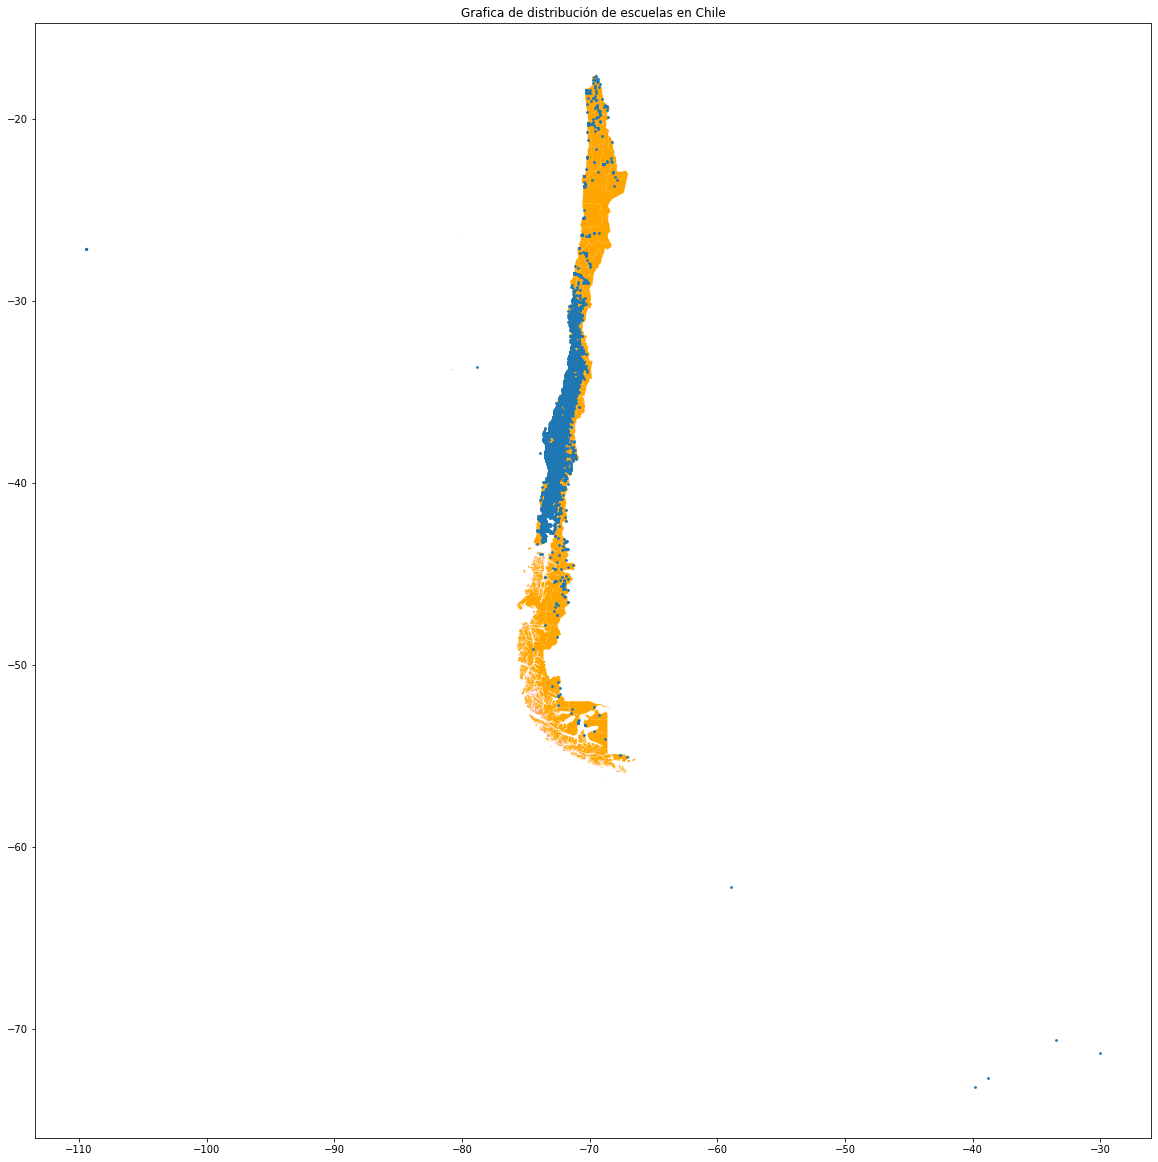

In [19]:
ruta_cartografia = path.join("DivisionPoliticoAdministrativa2020", "COMUNA", "COMUNAS_2020.shp")
comunas = gpd.read_file(ruta_cartografia).to_crs(4326)
# y ploteamos los datos del geodataframe
plot_mapa = comunas.plot(color = "orange", figsize=(20, 50))
datos_compacto_2021.plot(ax = plot_mapa, markersize=3)
plot_mapa.set_title("Grafica de distribución de escuelas en Chile")

In [20]:
geometry = datos_compacto_2021[["RBD", "NOM_RBD", "geometry"]]

In [21]:
datos_compacto_2021.drop("geometry", axis = 1, inplace=True)

##### Apertura de datos para agregar al dataframe

In [22]:
subencion = pd.read_csv("20220509_Detalle Subvenciones 2021_20220413.csv", sep=";", encoding="ISO-8859-1")

In [23]:
subencion = subencion.groupby("NOM_RBD").mean().reset_index()
subencion.drop(["AGNO", "COD_DEPE2", "COD_REG_RBD", "COD_PRO_RBD", "COD_COM_RBD"], axis = 1, inplace = True)

In [24]:
subencion["RBD"] = subencion["RBD"].astype(np.int64)

In [25]:
ingreso = pd.read_csv("Ingresos_medios_2010-2021.csv", sep=",")

In [26]:
ingreso = ingreso[ingreso["agno"] == 2021]

In [27]:
ingreso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 187 to 203
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   agno         17 non-null     int64  
 1   region       17 non-null     int64  
 2   ingre_medio  17 non-null     float64
 3   inter_inf    17 non-null     float64
 4   inter_sup    17 non-null     float64
 5   calidad      17 non-null     object 
dtypes: float64(3), int64(2), object(1)
memory usage: 952.0+ bytes


In [29]:
ingreso.rename(columns={"region":"COD_REG_RBD"}, inplace = True)

In [30]:
ingreso = ingreso[["COD_REG_RBD", "ingre_medio"]]

In [31]:
resumen_docente = pd.read_csv("Dotacion_docente_2021.csv", sep=";")[["RBD", "NOM_RBD", "DC_TOT"]]

In [32]:
evaluacion = pd.read_csv("20201104_SNED_2020_2021.csv", sep=";")[["RBD", "NOM_RBD", "EFECTIVR", "MEJORAR", "IGUALDR"]]

In [33]:
evaluacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10780 entries, 0 to 10779
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RBD       10780 non-null  int64 
 1   NOM_RBD   10780 non-null  object
 2   EFECTIVR  10780 non-null  object
 3   MEJORAR   10780 non-null  object
 4   IGUALDR   10780 non-null  object
dtypes: int64(1), object(4)
memory usage: 421.2+ KB


In [34]:
evaluacion.replace(" ", 0, inplace=True)

In [35]:
evaluacion["EFECTIVR"]= evaluacion["EFECTIVR"].str.replace(",",".").astype(np.float64)
evaluacion["MEJORAR"] = evaluacion["MEJORAR"].str.replace(",",".").astype(np.float64)
evaluacion["IGUALDR"]= evaluacion["IGUALDR"].str.replace(",",".").astype(np.float64)

##### Agregamos los datos ajustados

In [36]:
datos_compacto_2021 = datos_compacto_2021.merge(subencion, how="left", on = ["RBD", "NOM_RBD"])

In [37]:
datos_compacto_2021 = datos_compacto_2021.merge(ingreso, how="left", on = "COD_REG_RBD")

In [38]:
datos_compacto_2021 = datos_compacto_2021.merge(resumen_docente, how="left", on = ["RBD", "NOM_RBD"])

In [39]:
datos_compacto_2021 = datos_compacto_2021.merge(evaluacion, how="left", on = ["RBD", "NOM_RBD"])

###### Limpieza de datos para el cluster kmeans

In [40]:
datos_compacto_2021 = datos_compacto_2021.dropna()

In [41]:
datos_compacto_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2137 entries, 0 to 15422
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGNO                     2137 non-null   int64  
 1   RBD                      2137 non-null   object 
 2   NOM_RBD                  2137 non-null   object 
 3   COD_REG_RBD              2137 non-null   int64  
 4   COD_PRO_RBD              2137 non-null   int64  
 5   COD_COM_RBD              2137 non-null   int64  
 6   NOM_COM_RBD              2137 non-null   object 
 7   COD_DEPE2                2137 non-null   int64  
 8   NEM                      2137 non-null   float64
 9   rut_sostenedor           2137 non-null   float64
 10  COD_DEPROV_RBD           2137 non-null   float64
 11  COD_DEPE                 2137 non-null   float64
 12  RURAL_RBD                2137 non-null   float64
 13  mes                      2137 non-null   float64
 14  matricula              

In [42]:
datos_compacto_2021 = datos_compacto_2021[['AGNO', 'RBD', 'NOM_RBD', 'COD_REG_RBD', 'COD_PRO_RBD', 'COD_COM_RBD', 'NOM_COM_RBD', 'COD_DEPE2', 'NEM', "subv_normal", "ingre_medio", "DC_TOT", "EFECTIVR", "MEJORAR", "IGUALDR"]]

In [43]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(datos_compacto_2021[["AGNO", "COD_DEPE2", "NEM", "subv_normal", "ingre_medio", "DC_TOT", "EFECTIVR", "MEJORAR", "IGUALDR"]])
data_sc

array([[ 0.        ,  3.60672325, -1.21043745, ..., -1.76859159,
         0.22618629, -1.56164603],
       [ 0.        ,  3.60672325,  1.58920348, ...,  0.4447285 ,
         0.22618629,  0.6931764 ],
       [ 0.        ,  3.60672325,  1.74624716, ...,  0.61641518,
         0.22618629,  0.59000204],
       ...,
       [ 0.        ,  0.17554611, -0.57587581, ..., -0.43055254,
        -8.4310098 , -0.18901465],
       [ 0.        ,  0.17554611, -1.30996155, ..., -0.79779742,
         0.22618629,  0.1638244 ],
       [ 0.        ,  0.17554611, -3.05341521, ...,  0.38103614,
         0.22618629,  0.2482032 ]])

In [44]:
inertia=[]
kmax=20
for i in range(1,kmax):

    kmeans = KMeans(n_clusters=i,n_init=10)
    kncl= kmeans.fit(data_sc)

    print(i,kncl.inertia_)
    inertia.append(kncl.inertia_)

1 17095.999999999996
2 13847.285137327834
3 12206.43471330174
4 10657.099323522361
5 9122.570293263312
6 8122.690718087562
7 7138.507371877006
8 6507.395769937767
9 6134.574819691815
10 5821.911545295211
11 5538.050192607227
12 5329.389190685189
13 5080.676204427631
14 4865.8173859863155
15 4747.35500932408
16 4602.734831001826
17 4495.572715658922
18 4344.050072559646
19 4237.023766731672


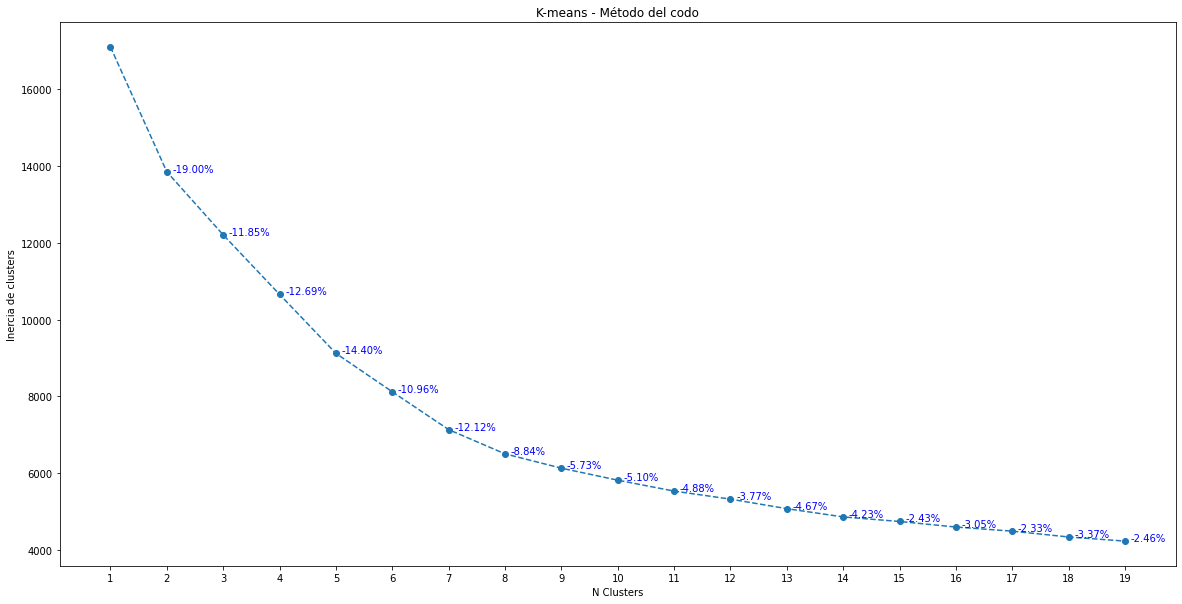

In [45]:
f, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(range(1,kmax),inertia,marker='o',ls='--')
ax.set_xlabel('N Clusters')
ax.set_ylabel('Inercia de clusters')
ax.set_title('K-means - Método del codo')

for i in range(1,len(inertia)):
    delta=(-inertia[i-1]+inertia[i])/inertia[i-1]*100
    ax.text(i+1.1,inertia[i],'%.2f'%delta+'%',color='b')
ax.set_xticks(range(1,kmax))

plt.show()

In [46]:
k=7

# Inicializamos la instancia  KMeans 
kmeans = KMeans(n_clusters=k,random_state=0)


# Correr el algoritmo sobre el conjunto de variable normalizadas
kcls = kmeans.fit(data_sc)


In [47]:
datos_compacto_2021['kcls_labels'] = kcls.labels_

In [48]:
centers = kcls.cluster_centers_
centers_i = scaler.inverse_transform(centers)

centers_i

array([[2.02100000e+03, 5.00000000e+00, 5.67674526e+00, 6.40535142e+07,
        6.16853659e+05, 4.78240741e+01, 3.36685885e+01, 9.98765432e+01,
        9.08350770e+01],
       [2.02100000e+03, 1.88316151e+00, 6.05041723e+00, 7.25190142e+07,
        6.34168179e+05, 4.45412371e+01, 5.26132638e+01, 9.98739977e+01,
        9.39352075e+01],
       [2.02100000e+03, 1.71428571e+00, 5.74248848e+00, 7.54197130e+07,
        6.51870462e+05, 4.73928571e+01, 3.93960022e+01, 9.82142857e+01,
        6.37565235e+01],
       [2.02100000e+03, 1.75593220e+00, 5.85126687e+00, 1.64467733e+08,
        6.89497804e+05, 8.78677966e+01, 4.79801636e+01, 9.98983051e+01,
        9.31317099e+01],
       [2.02100000e+03, 1.65075922e+00, 5.64180086e+00, 6.09929959e+07,
        7.79132492e+05, 4.04598698e+01, 3.65684634e+01, 9.98843095e+01,
        9.06692053e+01],
       [2.02100000e+03, 1.42833052e+00, 5.66719675e+00, 5.15355033e+07,
        5.70397726e+05, 3.84620573e+01, 3.51176880e+01, 9.98257448e+01,
        9.1

In [49]:
datos_compacto_2021 = datos_compacto_2021.merge(geometry, on = ["RBD", "NOM_RBD"])


In [50]:
datos_compacto_2021 = gpd.GeoDataFrame(datos_compacto_2021)

Text(0.5, 1.0, 'Grafica de distribución de escuelas en Chile')

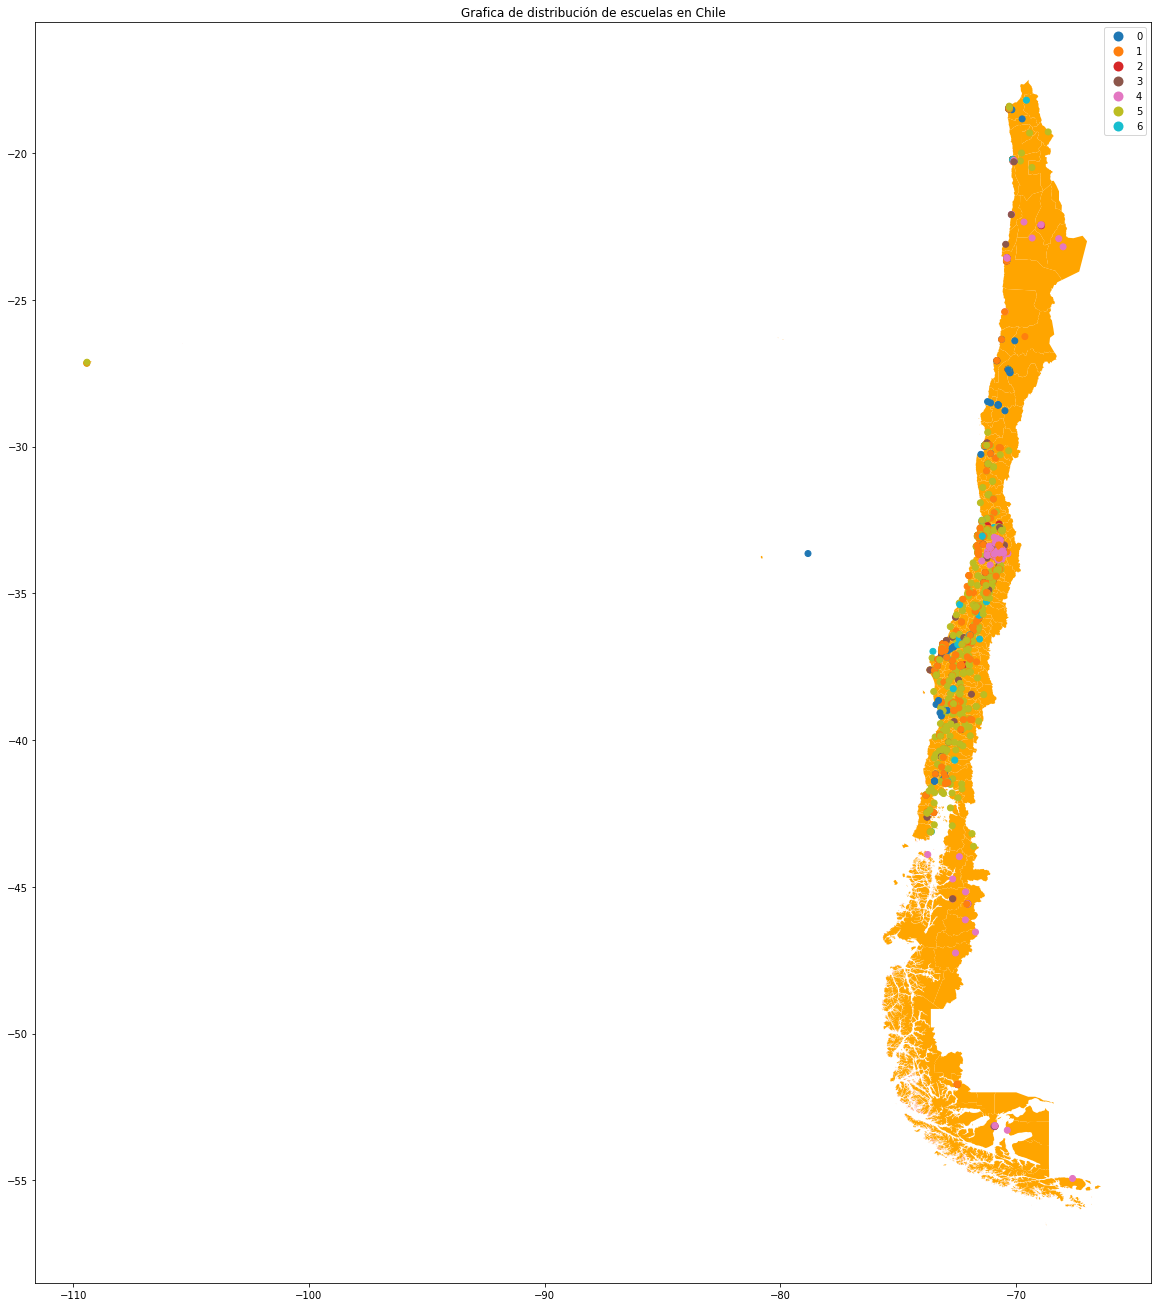

In [51]:
ruta_cartografia = path.join("DivisionPoliticoAdministrativa2020", "COMUNA", "COMUNAS_2020.shp")
comunas = gpd.read_file(ruta_cartografia).to_crs(4326)
# y ploteamos los datos del geodataframe
plot_mapa = comunas.plot(color = "orange", figsize=(20, 50))
datos_compacto_2021.plot(ax = plot_mapa, column = "kcls_labels", categorical = True, legend = True)
plot_mapa.set_title("Grafica de distribución de escuelas en Chile")



##### Obtenemos los promedios de los cluster

In [52]:
values = datos_compacto_2021.groupby(by = "kcls_labels").mean().sort_values(by="NEM")
datos_compacto_2021.groupby(by = "kcls_labels").mean().sort_values(by="NEM")[["AGNO", "COD_DEPE2", "NEM", "subv_normal", "ingre_medio", "DC_TOT", "EFECTIVR", "MEJORAR", "IGUALDR"]]

,AGNO,COD_DEPE2,NEM,subv_normal,ingre_medio,DC_TOT,EFECTIVR,MEJORAR,IGUALDR
kcls_labels,,,,,,,,,
4,2021.0,1.650000,5.641046,6.081395e+07,779129.619721,40.408696,36.586729,99.884058,90.671032
5,2021.0,1.428331,5.667197,5.153550e+07,570397.726161,38.462057,35.117688,99.825745,91.457801
0,2021.0,5.000000,5.676745,6.405351e+07,616853.658945,47.824074,33.668589,99.876543,90.835077
2,2021.0,1.714286,5.742488,7.541971e+07,651870.461616,47.392857,39.396002,98.214286,63.756524
6,2021.0,1.942857,5.773169,6.802887e+07,618522.723962,44.571429,41.520407,88.666667,91.907570
3,2021.0,1.756757,5.851732,1.643964e+08,689805.088003,87.787162,47.913225,99.898649,93.120551
1,2021.0,1.883162,6.050417,7.251901e+07,634168.179144,44.541237,52.613264,99.873998,93.935207


##### Una muestra de los datos

In [54]:
datos_compacto_2021.head()

,AGNO,RBD,NOM_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPE2,NEM,subv_normal,ingre_medio,DC_TOT,EFECTIVR,MEJORAR,IGUALDR,kcls_labels,geometry
0,2021,1,LICEO POLITECNICO ARICA,15,151,15101,ARICA,5,5.488641,7.234019e+07,582645.93457,71.0,23.437452,100.0,85.135741,0,POINT (-70.29521 -18.48720)
1,2021,4,LICEO OCTAVIO PALMA PEREZ,15,151,15101,ARICA,5,6.200546,1.274158e+08,582645.93457,64.0,46.872478,100.0,94.777983,0,POINT (-70.30827 -18.47424)
2,2021,5,JOVINA NARANJO FERNANDEZ,15,151,15101,ARICA,5,6.240480,1.140461e+08,582645.93457,70.0,48.690327,100.0,94.336781,0,POINT (-70.31345 -18.47690)
3,2021,7,L. POLI. ANTONIO VARAS DE LA BARRA,15,151,15101,ARICA,5,5.617087,1.522742e+08,582645.93457,99.0,29.168294,100.0,92.306536,0,POINT (-70.28837 -18.47615)
4,2021,8,COLEGIO INTEGRADO EDUARDO FREI MONTALVA,15,151,15101,ARICA,5,5.612941,9.943901e+07,582645.93457,58.0,38.695490,100.0,91.764478,0,POINT (-70.31758 -18.48249)
